# WER Evaluation with WAV2VEC and Single DSing Example

## Summary

1. Loading WAV2VEC model
2. Creating a Huggingface dataset for batch processing by Cropping the DSing Dataset described below (8 songs for each split, 1.5seconds max)

The dataset is cropped to allow for processing examples for this notebook.  in the actual processing, it will look different.<br>

Heavily inspired by: https://huggingface.co/blog/fine-tune-wav2vec2-english<br>

## DSing Dataset 

Reading data from DSing Dataset.  Filesystem formatted this way to convert easily to huggingface dataset.

where: <br>
dev/test/trainX are datasets split.<br>
\[split\]_text contains transcript for the snippet.<br>
\[split\]_spk2gender contains information about gender for snippet.<br>

Tests Split: 480 Utterances, 48 minutes<br>
Dev Split: 482 Utterances, 41 minutes<br>
Train1 Split: 8794 Utterances, 15.1 hours<br>
Train3 Split: 25526 Utterances, 44.7 hours<br>
Train30 Split: 268,392 Utterances, 149.1 hours<br>

sing_300x30x2/dataset/<br>
├── dev/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── dev_spk2gender<br>
├── dev_text<br>
├── test/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── test_spk2gender<br>
├── test_text<br>
├── train1/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── train1_spk2gender<br>
├── train1_text<br>
├── train3/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── train3_spk2gender<br>
└── train3_text<br>
├── train30/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── train30_spk2gender<br>
├── train30_text<br>


In [1]:
import os
import sys
import time
import glob
import re
import json
import random
import tqdm

import torch
import torchaudio
import evaluate

import pandas as pd
import numpy as np
import IPython

from IPython.display import display, HTML, Audio

from datasets import load_dataset, load_metric, ClassLabel, DatasetDict

from torch.utils.data import DataLoader

from torchaudio.models.decoder import ctc_decoder
from torchaudio.models.decoder import download_pretrained_files

from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import AutoFeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import AutoModelForCTC
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import pipeline

from transformers import TrainingArguments, Trainer

#
# Dataset unpacked and preprocessed into child folder dataset/
# DSing is around 200GB of data.
#
dataset_folder = "../sing_300x30x2/damp_dataset"

In [2]:
# Create Pipeline
model_checkpoint="facebook/wav2vec2-large-960h-lv60-self"
asr_pipeline = pipeline("automatic-speech-recognition", model=model_checkpoint)
model = asr_pipeline.model

# Note: I want to use a beam search library that has been pre-trained on librispeech.  the pretrained data 
#       has been created with all lowercase characters.  I am changing the tokenizer vocab settings to accept 
#       lower case inputs.  However, it will also accept upper case, so there's there.  This may also impact 
#       performance.
asr_pipeline.tokenizer.do_lower_case = True

target_sampling_rate = asr_pipeline.feature_extractor.sampling_rate

Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.maske

## Decoders

In [3]:
files = download_pretrained_files("librispeech-4-gram")
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens='./tokens.txt',
    lm=files.lm,
    nbest=1,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
    blank_token='<pad>',
    unk_word='<unk>'
)

greedy_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens='./tokens.txt',
    lm=files.lm,
    nbest=1,
    beam_size=1,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
    blank_token='<pad>',
    unk_word='<unk>'
)

# Generate Hugginface Dataset Object from DAMP 300x30x2 dataset

Reference: https://huggingface.co/docs/datasets/audio_load

Other pre-processing is heavily inspired from: https://colab.research.google.com/drive/1nCC5Ci-81U5opK_VuXDiZlmcAuATreF2#scrollTo=RBDRAAYxRE6n



In [4]:
# read labels for all song utterances for DSING splits (test, dev (aka validation), train1 (aka train)

# This object will create a datasetDict for train, validation and test
#dsing = load_dataset("audiofolder", data_dir=dataset_folder)

# Note: creating small dataset objects to ensure training goes well.
#       However, a limitation of using the audiofolder is that I cannot specify how much of
#       the data to read in.
dsing_small_train, dsing_small_val, dsing_small_test = load_dataset("audiofolder", data_dir=dataset_folder, split=['train[:16]','validation[:16]','test[:16]'])

# When using split with a list, the return objects are DataSet objects of size of list.
# Recasting back to DatasetDict for ease of use downstream.
dsing = DatasetDict({"train": dsing_small_train, "validation": dsing_small_val, "test":dsing_small_test})

Resolving data files:   0%|          | 0/8797 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/485 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/483 [00:00<?, ?it/s]

In [5]:
print(dsing['train'].format['type'])

None


In [6]:
waveform = dsing['test'][0]['audio']['array']
sampling_rate = dsing['test'][0]['audio']['sampling_rate']
display(dsing['test'][0])
display(Audio(waveform, rate=int(sampling_rate))) 

{'audio': {'path': '/Users/das/DATASCI266/sing_300x30x2/damp_dataset/test/F1044589619-227666925_216090-1044588651_1569152519-GB-F-012.wav',
  'array': array([ 0.00064087,  0.00424194,  0.00299072, ..., -0.01693726,
         -0.00616455, -0.00930786]),
  'sampling_rate': 16000},
 'transcription': 'STOP MAKING A FOOL OUT OF ME'}

# Data Cleaning

In [7]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [8]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["transcription"] = re.sub(chars_to_ignore_regex, '', batch["transcription"]).lower() + " "
    return batch

dsing = dsing.map(remove_special_characters)
show_random_elements(dsing['test'].remove_columns(['audio']), num_examples=5)

,transcription
0,valerie valerie valerie
1,why don't you come over valerie
2,and in my head i paint a picture
3,are you shopping anywhere
4,and i've missed your ginger hair and the way you like to dress


Max Length for Data Padding: 236064 or 14.75 seconds.
Max Length for Text Padding: 136.
85th Percentile Time Window: 9.1 seconds


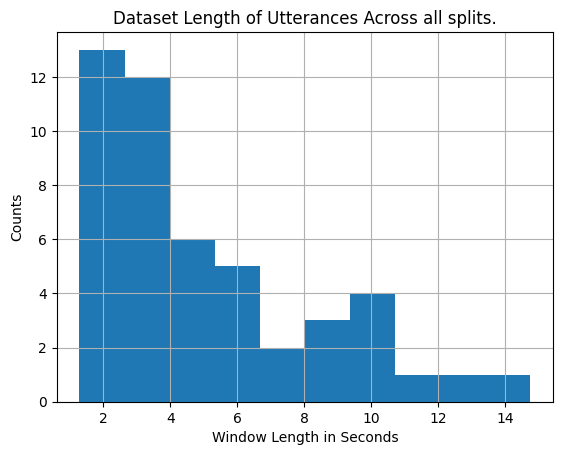

In [9]:
def get_max_sequence_length(dataset):
    max_data_length = 0
    max_text_length = 0

    utt_hist = []
    for split in ['train','validation','test']:
        for split_ds in dataset[split]:
            data_length = len(split_ds['audio']['array'])
            text_length = len(split_ds['transcription'])

            utt_hist.append(data_length)
            #print(length,end=',')
            if data_length > max_data_length:
                max_data_length=data_length

            if text_length > max_text_length:
                max_text_length=text_length
    
    return max_data_length, max_text_length, utt_hist
    
max_data_length, max_text_length, utt_hist  = get_max_sequence_length(dsing)
print(f"Max Length for Data Padding: {max_data_length} or {max_data_length/16000:.2f} seconds.")
print(f"Max Length for Text Padding: {max_text_length}.")


max_length_ds = pd.Series([l / 16000. for l in utt_hist])
# Calculate What the Window Length Would need to be to include 85% of the data.
print(f"85th Percentile Time Window: {max_length_ds.quantile(q=0.85):.1f} seconds")
ax = max_length_ds.hist();
ax.set_title('Dataset Length of Utterances Across all splits.')
ax.set_xlabel('Window Length in Seconds');
ax.set_ylabel("Counts");

In [10]:
def prepare_dataset(batch,tokenizer,feature_extractor):
    """
    Creating a new dataset with the map function to generate the 
    keys below.  Padding will occur in the data collator on a per
    batch basis. 

    Inputs (i.e. feature extractor):
    input_values   - tensor array for audio samples (shape=(n,) - where n is the number of audio samples)
    attention_mask - used for expressing where there are padded samples 

    Outputs (i.e. tokenizer related)
    labels - tensor array for text output tokens (i.e. not transcript).  (shape=(m,) - where m is the number of character tokens)
    """
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct

    # Feature Extractor manipulation
    #
    # this object will return a list of lists because the 
    # transcriptions are not padded (i.e. as opposed to a 
    # Tensor of tensors when using return_tensors='pt').
    # Padding is done per batch to optimize the size for inference and 
    # training.
    #
    # data_collator is responsible for padding the data.
    inputs_values_pt = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"])
    batch["attention_mask"] = inputs_values_pt.attention_mask
    batch["input_values"] = inputs_values_pt.input_values[0]

    # Tokenizer manipulation
    #
    # this object will return a list of lists because the 
    # transcriptions are not padded (i.e. as opposed to a 
    # Tensor of tensors when using return_tensors='pt').
    # Padding is done per batch to optimize the size for inference and 
    # training.
    #
    # data_collator is responsible for padding the data.
    labels_pt = tokenizer(batch["transcription"])
    batch["labels"] = labels_pt['input_ids']
    
    return batch

In [11]:
# Create dataset keys that are expected by model for each split.
# 
dsing.set_format(type="python")
#
# I am shortening the dataset to allow the notebook to run fast and not run out of memory on my machine while doing batches of data.
# to run this for the full utterances, use the following...
#max_data_length, max_text_length, _ = get_max_sequence_length(dsing)
max_data_length, max_text_length = 25000, 94

dsing_dataset = dsing.map(prepare_dataset, remove_columns=["audio","transcription"], num_proc=1, fn_kwargs={'tokenizer':asr_pipeline.tokenizer, 'feature_extractor':asr_pipeline.feature_extractor})

In [12]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the already tokenized inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).

            Other Options in the pad method that are NOT implemented for this class (i.e. I always want to pad to longest for the 
            input and the labels)
            * (not implemented) :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * (not implemented) :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).

    Reference Code here:
    https://huggingface.co/blog/fine-tune-wav2vec2-english

    
    Note: in the example referenced above, there were parameters for padding max length, etc.  I have created some logic 
    in the prepare_dataset to support truncation of data for testing and benchmarking.  I do not think i need max_length 
    options for collator at this time.

    """
    
    tokenizer: Wav2Vec2CTCTokenizer
    feature_extractor: Wav2Vec2FeatureExtractor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        
        # Features in this case is a list of batch size that contains DataSet objects from the train split
        # (including pretokenized labels). the output batch has been changed from a list back to a dictionary 
        # with the respective data objects.
        #
        # Note for future self: 
        # pad is being called from PreTrainedTokenizerBase.pad.  From docs:
        #      Pad a single encoded input or a batch of encoded inputs up to predefined length or to the max sequence length
        #      in the batch.
        #      
        #    Padding side (left/right) padding token ids are defined at the tokenizer level (with `self.padding_side`,
        #    `self.pad_token_id` and `self.pad_token_type_id`).

        #    Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the
        #    text followed by a call to the `pad` method to get a padded encoding.
        # 
        #         <Tip>
        # 
        #         If the `encoded_inputs` passed are dictionary of numpy arrays, PyTorch tensors or TensorFlow tensors, the
        #         result will use the same type unless you provide a different tensor type with `return_tensors`. In the case of
        #         PyTorch tensors, you will lose the specific device of your tensors however.
        # 
        #         </Tip>

        # Audio Input Data (not tokenized)
        input_features = [{"input_values": feature["input_values"]} for feature in features]

        # batch is a dictionary-like type.
        batch = self.feature_extractor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        
        # Tokenized Transcript Labels (character level tokens)
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.tokenizer.pad(
            label_features,
            padding=self.padding,
            return_tensors="pt",
        )
        
        # replace padding with -100 to ignore loss correctly
        batch["labels"] = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        
        return batch

In [13]:
wer_metric = evaluate.load("wer")

def compute_metrics(eval_pred,kind='beam',compute=True):
    """
    Calculates WER for a batch of logits and their labels.

    eval_pred - tuple (logit output from the model, token labels from dataset)
    kind - can compare between beam search and greedy search.  both using kenlm 

    compute - bool - for training this will compute WER every time its logged.  
                     this is nice for understanding if the training is working.
                     for evaluation, this is set to false so compute is run after
                     all batches are processed.

    output is the WER computed from the batch.  if the model is run multiple times, the 
    batch WERs are aggregated.

    Note: add_batch and then doing compute will clear the previously cached batch results.
    """
    logits, labels = eval_pred
    #print(f"Logit Type: {type(logits)}")

    logits = logits.clone().detach().requires_grad_(False)    
    #print(f"Changing Logit Type to: {type(logits)}")
    #print(f"{logits.shape}")
    
    if kind=='beam':
        # Creates a list of lists that are of size [batch_size,emissions,vocab_size]
        #
        # Where output[0][0] gives you the CTCHypothesis object.
        #
        # Extract transcript from output[0][0].words (i.e. list of words).  
        # May need to join depending on objective.
        #
        predictions = beam_search_decoder(logits)
    elif kind=='greedy':
        # Creates a list of lists that are of size [batch_size,1]
        #
        # Where output[0][0] gives you the CTCHypothesis object.
        #
        # Extract transcript from output[0][0].words (i.e. list of words).  
        # May need to join depending on objective.
        #
        predictions = greedy_decoder(logits)
    else:
        print(f"Error passing in decoder kind: {kind}")
        sys.exit()

    ref = asr_pipeline.tokenizer.batch_decode(labels)
    pred = [" ".join(prediction[0].words) for prediction in predictions]

    wer_metric.add_batch(predictions=pred, references=ref)

    if compute: 
        return {"wer":wer_metric.compute()}

    return None
    

In [14]:
#
# Simple logic to calculate exactly how much data i'm processing through the model
#
sample_rate = dsing['test']['audio'][0]['sampling_rate']
split_durations = {'test':0,'validation':0,'train':0}
for split in ['test','validation','train']:
    duration_seconds = 0
    for waveform in dsing_dataset[split]['input_values']:
        duration_seconds += len(waveform) / sample_rate
        split_durations[split] = duration_seconds

split_durations   

{'test': 85.03868749999998, 'validation': 96.992, 'train': 57.512}

In [15]:
data_collator = DataCollatorCTCWithPadding(
    tokenizer=asr_pipeline.tokenizer, 
    feature_extractor=asr_pipeline.feature_extractor
)

# simulate the manipulation the model does to take the dataset
collator_output = data_collator(dsing_dataset['train'])
collator_output['labels'].shape

torch.Size([16, 136])

# Simple Inference Example Batch Size == 1 (Good for Testing)

In [16]:
#
# Shape Notes: 
# dsing_dataset['test']['input_values'].shape = torch.Size([8, N])
#
# where 8 is the number of rows in the dataset.
#       N is the number of padded samples in the waveform (padded to the max tensor size for a batch.  
#         Note: padding is done in the DataColator
# 
# output is of size torch.Size([8, E, 32])
# 
# where 8 is the rows in the dataset (or batch_size)
#       E is the number of emissions
#       32 is the vocab size (characters, apostrophe, plus other special tokens for spaces and CTC considerations)
# 
# If you want to play a song and see transcript:
# print(asr_pipeline.tokenizer.batch_decode(dsing_dataset['validation']['labels']))
# display(Audio(dsing_dataset['test']['input_values'][0], rate=int(sampling_rate))) 
#

# Collators pads inputs and labels inspired by 
# https://huggingface.co/blog/fine-tune-wav2vec2-english
inputs = data_collator(dsing_dataset['test'])

start = time.time()
with torch.no_grad():
    logits = model(**inputs).logits 
finish = time.time()
wer = compute_metrics((logits,dsing_dataset['test']['labels']))
print(f"WER for batch (lower is better): {wer['wer']*100:.1f}%")
num_utts = dsing_dataset['test'].num_rows
total_audio_time = split_durations['test']*num_utts
print(f"Inference took: {finish-start:.1f} seconds for {total_audio_time:.1f} seconds of data.  Real Time Factor: {total_audio_time / (finish-start):.1f}")


WER for batch (lower is better): 42.1%
Inference took: 24.1 seconds for 1360.6 seconds of data.  Real Time Factor: 56.4


## Manual WER analysis for Model Logits

In [17]:
labels = dsing_dataset['test']['labels']
ref = asr_pipeline.tokenizer.batch_decode(labels)
ref

['stop making a fol out of me',
 'valerie',
 'are you shoping anywhere',
 "and i've mised your ginger hair",
 'and the way you like to dres',
 "why don't you come on over valerie",
 'valerie valerie valerie',
 'and in my head i paint a picture',
 "and i've mised your ginger hair and the way you like to dres",
 "stop making a fol out of me why don't you come on over valerie",
 "why don't you come over valerie",
 "wait 'til you se my baby move move move",
 'dear future husband',
 "dear future husband here's a few things you'l ned to know if you wana be my one and only al my life",
 'to test the limits and break throug',
 "i'm never going back"]

In [18]:
predictions = beam_search_decoder(logits)
pred = [" ".join(prediction[0].words) for prediction in predictions]
pred

['stop making a fool',
 'run away',
 'are you stopping anywhere',
 'and mister ginger hair',
 'and the way you like the dress',
 "why don't you come on over here",
 'val val',
 'and in my hand i paint a picture',
 "and i've missed you ginger hair and the way you like to dress",
 "stop making a fool why don't you come over",
 "why don't you come over",
 'for my baby',
 'her future husband',
 "her future husband here's a few things to know if you want to be my morning only all my life",
 'the year through',
 'going back']

In [19]:
wer_metric.compute(predictions=pred, references=ref)

0.4214876033057851

# Batch Evalation (no training)

In [20]:
num_utts = dsing_dataset['test'].num_rows
total_audio_time = split_durations['test']*num_utts

data_loader = DataLoader(
    dsing_dataset['test'],
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=data_collator
)

total_start = time.time()
batch_inference_time = []
for batch in data_loader: 
    start = time.time()
    with torch.no_grad():
        logits = model(**batch).logits 
    finish = time.time()
    batch_inference_time.append(finish-start)
    compute_metrics((logits,batch.labels),compute=False)
    print(f"Batch Inference took: {finish-start:.1f} seconds.")
    print("*******************")
total_finish = time.time()
total_processing_time = total_finish-total_start
total_inference_time = np.sum(batch_inference_time)
total_dataloading_time = total_processing_time - total_inference_time
print(f"Batch Inference took: {total_processing_time:.1f} seconds for {total_audio_time:.1f} seconds of data.  Real Time Factor: {total_audio_time / (total_processing_time):.1f}")
print(f"Inference: {total_inference_time:.1f} seconds, DataLoading: {total_dataloading_time:.1f} seconds") 
print(f"WER for all batches (lower is better): {wer_metric.compute()*100:.1f}%")

Batch Inference took: 1.5 seconds.
*******************
Batch Inference took: 5.1 seconds.
*******************
Batch Inference took: 4.2 seconds.
*******************
Batch Inference took: 4.4 seconds.
*******************
Batch Inference took: 33.1 seconds for 1360.6 seconds of data.  Real Time Factor: 41.1
Inference: 15.2 seconds, DataLoading: 17.9 seconds
WER for all batches (lower is better): 46.6%


# Evaluation with Shuffle Performance

Testing using the Shuffle Feature (in case I need to use it)<br>
Generally, WER should be the same and time to load / infer should be worse in some way.

In [21]:
num_utts = dsing_dataset['test'].num_rows
total_audio_time = split_durations['test']*num_utts

data_loader = DataLoader(
    dsing_dataset['validation'],
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=data_collator
)

total_start = time.time()
batch_inference_time = []
for batch in data_loader: 
    start = time.time()
    with torch.no_grad():
        logits = model(**batch).logits 
    finish = time.time()
    batch_inference_time.append(finish-start)
    compute_metrics((logits,batch.labels),compute=False)
    #print(f"Batch Inference took: {finish-start:.1f} seconds.")
    #print("*******************")

total_finish = time.time()
total_processing_time = total_finish-total_start
total_inference_time = np.sum(batch_inference_time)
total_dataloading_time = total_processing_time - total_inference_time
print(f"Batch Inference took: {total_processing_time:.1f} seconds for {total_audio_time:.1f} seconds of data.  Real Time Factor: {total_audio_time / (total_processing_time):.1f}")
print(f"Inference: {total_inference_time:.1f} seconds, DataLoading: {total_dataloading_time:.1f} seconds") 
print(f"WER for all batches (lower is better): {wer_metric.compute()*100:.1f}%")

Batch Inference took: 41.2 seconds for 1360.6 seconds of data.  Real Time Factor: 33.1
Inference: 19.2 seconds, DataLoading: 22.0 seconds
WER for all batches (lower is better): 32.0%
